# Data

Нам дали датасет состоящий из ЭЭГ и ЭКГ. Все данные были размечены вручную специалистами (от 1 до 20+ на каждый ЭЭГ), на каждом участке ЭЭГ выделяли 10 центральных секунд и отнести к 1 из 6 классов:
1. Судороги (SZ)
2. Генерализованные эпилептические разряды (LPD)
3. Латеризованные эпилептические разряды (GPD)
4. Латерализованнная ритмическая дельта-активность (LRDA)
5. Генерализованная ритмическая дельта-активность (GRDA)
6. Прочее

Метрика KL-div (нормировали количество голосов на каждом ЭЭГ и использовали как предсказываюмую вероятность)


### Разделение данных
В зависимости от количества экспертов на кадом ЭЭГ определяется качество этих данных, то есть лучшая дата - с наибольшим количеством экспертов, что логично.
Так же выделенная категория 'other' кажется датой наименьшего качества, когда даже эксперты не могут определить класс.

Это наводит на мысль разделить на 
* дату высокого качества - >=10 голосов 
* дату низкого качества - <10 голосов.

Будем использовать self-training методы для этого:
https://arxiv.org/pdf/2301.07294.pdf


1. **Initial Training**: Обучение модели с данными на метках высокого качества
1. **Prediction on Low-Quality Labels**: Обучение модели с данными на метках низкого качества
1. **Label Refinement**: Генерация нового набора данных из псевдолейблинга на данных низкого качества и 50% высокого качества, сгенерированных моделью, 
1. **Training with Refined Labels**: обучение новой модели, теперь используя улучшенные метки, что значительно повысило производительность модели.
1. **Finetuning**: Финальная модель на всех данных

Идея взята из топовых публичных ноутбуков соревнования

### Новые спектограммы

Создаются новые спектограммы
1. Spec, предоставленный соревнованием: 10 минут данных.
1. кастомный Spec 1: 50 секунд данных (Увеличение в инференсном окне).
1. кастомный Spec 2: 10 секунд данных (Еще большее увеличение в инференсном окне).

Эти три спектрограммы были объединены в одну спектрограмму размером 512x512 пикселей, оптимизируя представление данных для обучения модели. Это все взято из датасетов и ноутбуков ниже
* Создание спектограм - [specGPU](https://www.kaggle.com/code/rafaelzimmermann1/hms-spectrogram-creation-using-gpu)
* датасет спектограм - [datasetspec](https://www.kaggle.com/datasets/rafaelzimmermann1/3-diff-time-specs-hms)

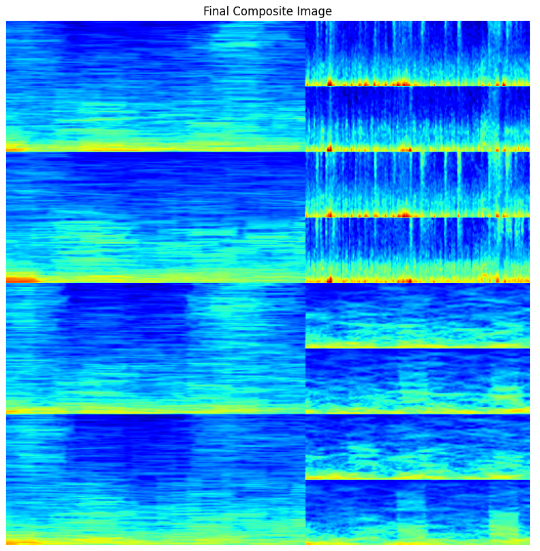

Далее решение блендится с другими двумя топовыми ноутбуками, которые остались неизменными, т.к. время сабмита позволяло несколько раз обрабатывать данные :)
* Вторая модель - 1D ResNet на 8 каналах (с лоссами Hardswish and SiLU, добавлением albumentations и другими аугментациями)
* Третья модель - ResNet34d, EfficientNetB0 and EfficientnetB1 обученные на сырых данных от Kaggle с обучением в две стадии

In [1]:
import tensorflow as tf
print(tf.__version__)


2024-05-14 13:01:34.908596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 13:01:34.908688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 13:01:35.173029: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


### Acknowledgements:

* Разделение данных
1. [link](https://www.kaggle.com/code/pcjimmmy/patient-variation-eda)
1. [link](https://www.kaggle.com/code/seanbearden/effnetb0-2-pop-model-train-twice-lb-0-39)

In [ ]:
import gc
import os
import random
import warnings
import numpy as np
import pandas as pd
from IPython.display import display

import timm
import torch
import torch.nn as nn  
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from scipy import signal

warnings.filterwarnings('ignore', category=Warning)
gc.collect()
class Config:
    seed = 3131
    image_transform = transforms.Resize((512, 512))
    num_folds = 5
    dataset_wide_mean = -0.2972692229201065 
    dataset_wide_std = 2.5997336315611026 
    ownspec_mean = 7.29084372799223e-05 
    ownspec_std = 4.510082606216031 
    
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(Config.seed)
test_df = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/test.csv")
submission = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv")

submission = submission.merge(test_df, on='eeg_id', how='left')
submission['path_spec'] = submission['spectrogram_id'].apply(lambda x: f"/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/{x}.parquet")
submission['path_eeg'] = submission['eeg_id'].apply(lambda x: f"/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/{x}.parquet")

display(submission)

gc.collect()

models = []

# EfficientnetB0
for i in range(Config.num_folds):
    model_effnet_b0 = timm.create_model('efficientnet_b0', pretrained=False, num_classes=6, in_chans=1)
    model_effnet_b0.load_state_dict(torch.load(f'/kaggle/input/hms-train-efficientnetb0/efficientnet_b0_fold{i}.pth', map_location=torch.device('cpu')))
    models.append(model_effnet_b0)
    
models_datawide = []
# EfficientnetB1
for i in range(Config.num_folds):
    model_effnet_b1 = timm.create_model('efficientnet_b1', pretrained=False, num_classes=6, in_chans=1)
    model_effnet_b1.load_state_dict(torch.load(f'/kaggle/input/train/efficientnet_b1_fold{i}.pth', map_location=torch.device('cpu')))
    models_datawide.append(model_effnet_b1)
    
models_ownspec = []
# EfficientnetB1 with new spectrograms
for i in range(Config.num_folds):
    model_effnet_b1 = timm.create_model('efficientnet_b1', pretrained=False, num_classes=6, in_chans=1)
    model_effnet_b1.load_state_dict(torch.load(f'/kaggle/input/efficientnet-b1-ownspectrograms/efficientnet_b1_fold{i}_datawide_CosineAnnealingLR_0.001_False.pth', map_location=torch.device('cpu')))
    models_ownspec.append(model_effnet_b1)
    
gc.collect()

test_predictions = []

def create_spectrogram(data): # Создание спектрограммы на основе данных ЭЭГ
    """This function will create a spectrogram based on EEG-data"""
    nperseg = 150  # длина одного сегмента
    noverlap = 128  # объединение сегментов
    NFFT = max(256, 2 ** int(np.ceil(np.log2(nperseg))))

    # LL Spec = ( spec(Fp1 - F7) + spec(F7 - T3) + spec(T3 - T5) + spec(T5 - O1) )/4
    freqs, t,spectrum_LL1 = signal.spectrogram(data['Fp1']-data['F7'],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LL2 = signal.spectrogram(data['F7']-data['T3'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LL3 = signal.spectrogram(data['T3']-data['T5'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LL4 = signal.spectrogram(data['T5']-data['O1'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)

    LL = (spectrum_LL1+ spectrum_LL2 +spectrum_LL3 + spectrum_LL4)/4

    # LP Spec = ( spec(Fp1 - F3) + spec(F3 - C3) + spec(C3 - P3) + spec(P3 - O1) )/4
    freqs, t,spectrum_LP1 = signal.spectrogram(data['Fp1']-data['F3'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LP2 = signal.spectrogram(data['F3']-data['C3'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LP3 = signal.spectrogram(data['C3']-data['P3'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LP4 = signal.spectrogram(data['P3']-data['O1'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)

    LP = (spectrum_LP1+ spectrum_LP2 +spectrum_LP3 + spectrum_LP4)/4

    # RP Spec = ( spec(Fp2 - F4) + spec(F4 - C4) + spec(C4 - P4) + spec(P4 - O2) )/4
    freqs, t,spectrum_RP1 = signal.spectrogram(data['Fp2']-data['F4'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_RP2 = signal.spectrogram(data['F4']-data['C4'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_RP3 = signal.spectrogram(data['C4']-data['P4'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_RP4 = signal.spectrogram(data['P4']-data['O2'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)

    RP = (spectrum_RP1+ spectrum_RP2 +spectrum_RP3 + spectrum_RP4)/4


    # RL Spec = ( spec(Fp2 - F8) + spec(F8 - T4) + spec(T4 - T6) + spec(T6 - O2) )/4
    freqs, t,spectrum_RL1 = signal.spectrogram(data['Fp2']-data['F8'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_RL2 = signal.spectrogram(data['F8']-data['T4'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_RL3 = signal.spectrogram(data['T4']-data['T6'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_RL4 = signal.spectrogram(data['T6']-data['O2'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    RL = (spectrum_RL1+ spectrum_RL2 +spectrum_RL3 + spectrum_RL4)/4
    spectogram = np.concatenate((LL, LP,RP,RL), axis=0)
    return spectogram

def preprocess_ownspec(path_to_parquet): #предобработка данных спектрограммы собственного спектра
    """The data will be processed from EEG to spectrogramdata"""
    data = pd.read_parquet(path_to_parquet)
    data = create_spectrogram(data)
    mask = np.isnan(data)
    data[mask] = -1
    data = np.clip(data, np.exp(-6), np.exp(10))
    data = np.log(data)
    
    return data 

def preprocess(path_to_parquet): # предобработка данных спектрограммы
    data = pd.read_parquet(path_to_parquet)
    data = data.fillna(-1).values[:, 1:].T
    data = np.clip(data, np.exp(-6), np.exp(10))
    data = np.log(data)
    
    return data


def normalize_datawide(data_point): # нормализация данных спектрограммы
    """The spectrogram data will be normalized data wide."""
    eps = 1e-6

    data_point = (data_point - Config.dataset_wide_mean) / (Config.dataset_wide_std + eps)

    data_tensor = torch.unsqueeze(torch.Tensor(data_point), dim=0)
    data_point = Config.image_transform(data_tensor)

    return data_point


def normalize_datawide_ownspec(data): # нормализация новых данных спектрограммы
    """The new spectrogram data will be normalized data wide."""
    eps = 1e-6
    
    data = (data - Config.ownspec_mean) / (Config.ownspec_std + eps)
    data_tensor = torch.unsqueeze(torch.Tensor(data), dim=0)
    data = Config.image_transform(data_tensor)
    
    return data


def normalize_instance_wise(data_point):
    """The spectrogram data will be normalized instance wise."""
    eps = 1e-6
    
    data_mean = data_point.mean(axis=(0, 1))
    data_std = data_point.std(axis=(0, 1))
    data_point = (data_point - data_mean) / (data_std + eps)
    
    data_tensor = torch.unsqueeze(torch.Tensor(data_point), dim=0)
    data_point = Config.image_transform(data_tensor)
    
    return data_point

for index in submission.index:
    test_predictions_per_model = []
    
    preprocessed_data = preprocess(submission.iloc[index]['path_spec'])
    preprocessed_data_ownspec = preprocess_ownspec(submission.iloc[index]['path_eeg'])
    
    # Предсказание на основе оригинальных моделей EfficientnetB0
    for i in range(len(models)):
        models[i].eval()
        
        current_parquet_data = normalize_instance_wise(preprocessed_data).unsqueeze(0)
        
        with torch.no_grad():
            model_output = models[i](current_parquet_data)
            current_model_prediction = F.softmax(model_output)[0].detach().cpu().numpy()
            
        test_predictions_per_model.append(current_model_prediction)
    
    # Предсказание на основе оптимизированных гиперпараметров EffcientnetB1
    for i in range(len(models_datawide)):
        models_datawide[i].eval()
        
        current_parquet_data = normalize_datawide(preprocessed_data).unsqueeze(0)
        
        with torch.no_grad():
            model_output = models_datawide[i](current_parquet_data)
            current_model_prediction = F.softmax(model_output)[0].detach().cpu().numpy()
            
        test_predictions_per_model.append(current_model_prediction)
    
    # Predict based on EfficientnetB1 model with new spectrograms.
    for i in range(len(models_ownspec)):
        models_ownspec[i].eval()
        
        current_parquet_data = normalize_datawide_ownspec(preprocessed_data_ownspec).unsqueeze(0)
        
        with torch.no_grad():
            model_output = models_ownspec[i](current_parquet_data)
            current_model_prediction = F.softmax(model_output)[0].detach().cpu().numpy()
            
        test_predictions_per_model.append(current_model_prediction)
    
    # The mean of all models is taken.
    ensemble_prediction = np.mean(test_predictions_per_model,axis=0)
    
    test_predictions.append(ensemble_prediction)

test_predictions = np.array(test_predictions)

gc.collect()

predss_3 = test_predictions
predss_3

In [ ]:
import os
import gc
import sys
import math
import time
import random
import datetime as dt
import numpy as np
import pandas as pd

from glob import glob
from pathlib import Path
from typing import Dict, List, Union
from scipy.signal import butter, lfilter, freqz
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

sys.path.append("/kaggle/input/kaggle-kl-div")
from kaggle_kl_div import score

import warnings

warnings.filterwarnings("ignore")

device = torch.device("cuda")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

!cat /etc/os-release | grep -oP "PRETTY_NAME=\"\K([^\"]*)"
print(f"BUILD_DATE={os.environ['BUILD_DATE']}, CONTAINER_NAME={os.environ['CONTAINER_NAME']}")

try:
    print(
        f"PyTorch Version:{torch.__version__}, CUDA is available:{torch.cuda.is_available()}, Version CUDA:{torch.version.cuda}"
    )
    print(
        f"Device Capability:{torch.cuda.get_device_capability()}, {torch.cuda.get_arch_list()}"
    )
    print(
        f"CuDNN Enabled:{torch.backends.cudnn.enabled}, Version:{torch.backends.cudnn.version()}"
    )
except Exception:
    pass
class CFG:
    VERSION = 88

    model_name = "resnet1d_gru"

    seed = 2024
    batch_size = 32
    num_workers = 0

    fixed_kernel_size = 5
    kernels = [3, 5, 7, 9, 11]
    linear_layer_features = 304   # 1/5  Signal = 2_000

    seq_length = 50  
    sampling_rate = 200 
    nsamples = seq_length * sampling_rate 
    out_samples = nsamples // 5

    freq_channels = [] 
    filter_order = 2
    random_close_zone = 0.0  # 0.2
        
    target_cols = [
        "seizure_vote",
        "lpd_vote",
        "gpd_vote",
        "lrda_vote",
        "grda_vote",
        "other_vote",
    ]


    map_features = [
        ("Fp1", "T3"),
        ("T3", "O1"),
        ("Fp1", "C3"),
        ("C3", "O1"),
        ("Fp2", "C4"),
        ("C4", "O2"),
        ("Fp2", "T4"),
        ("T4", "O2"),
        #('Fz', 'Cz'), ('Cz', 'Pz'),        
    ]

    eeg_features = ["Fp1", "T3", "C3", "O1", "Fp2", "C4", "T4", "O2"]  # 'Fz', 'Cz', 'Pz']
        # 'F3', 'P3', 'F7', 'T5', 'Fz', 'Cz', 'Pz', 'F4', 'P4', 'F8', 'T6', 'EKG']                    
    feature_to_index = {x: y for x, y in zip(eeg_features, range(len(eeg_features)))}
    simple_features = []  # 'Fz', 'Cz', 'Pz', 'EKG'
    
    n_map_features = len(map_features)
    in_channels = n_map_features + n_map_features * len(freq_channels) + len(simple_features)
    target_size = len(target_cols)
    
    PATH = "/kaggle/input/hms-harmful-brain-activity-classification/"
    test_eeg = "/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/"
    test_csv = "/kaggle/input/hms-harmful-brain-activity-classification/test.csv"
koef_1 = 1.0
model_weights = [
    {
        'bandpass_filter':{'low':0.5, 'high':20, 'order':2}, 
        'file_data': 
        [
            {'koef':koef_1, 'file_mask':"/kaggle/input/hms-resnet1d-gru-weights-v82/pop_2_weight_oof/*_best.pth"},
        ]
    },
]
def init_logger(log_file="./test.log"):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    return mu_x 


def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x


def mu_law_expansion(data, mu):
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(mu + 1)) - 1) / mu
    return s


def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype="band")


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def butter_lowpass_filter(
    data, cutoff_freq=20, sampling_rate=CFG.sampling_rate, order=4
):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data


def denoise_filter(x):
    # Частота дискретизации и желаемые частоты среза (в Гц).
    # Отфильтруйте шумный сигнал
    y = butter_bandpass_filter(x, CFG.lowcut, CFG.highcut, CFG.sampling_rate, order=6)
    y = (y + np.roll(y, -1) + np.roll(y, -2) + np.roll(y, -3)) / 4
    y = y[0:-1:4]
    return y
def eeg_from_parquet(
    parquet_path: str, display: bool = False, seq_length=CFG.seq_length
) -> np.ndarray:
    """
    Эта функция читает файл паркета и извлекает средние 50 секунд показаний. Затем он заполняет значения NaN
    со средним значением (игнорируя NaN).
        :param parquet_path: путь к файлу паркета.
        :param display: отображать графики ЭЭГ или нет.
        :return data: np.array формы (time_steps, eeg_features) -> (10_000, 8)
    """

    # Вырезаем среднюю 50 секундную часть
    eeg = pd.read_parquet(parquet_path, columns=CFG.eeg_features)
    rows = len(eeg)

    # начало смещения данных, чтобы забрать середину
    offset = (rows - CFG.nsamples) // 2

    # средние 50 секунд, имеет одинаковое количество показаний слева и справа
    eeg = eeg.iloc[offset : offset + CFG.nsamples]

    if display:
        plt.figure(figsize=(10, 5))
        offset = 0

    # Конвертировать в numpy

    # создать заполнитель той же формы с нулями
    data = np.zeros((CFG.nsamples, len(CFG.eeg_features)))

    for index, feature in enumerate(CFG.eeg_features):
        x = eeg[feature].values.astype("float32")  # конвертировать в float32

        # Вычисляет среднее арифметическое вдоль указанной оси, игнорируя NaN.
        mean = np.nanmean(x)
        nan_percentage = np.isnan(x).mean()  # percentage of NaN values in feature

        # Заполнение значения Nan
        # Поэлементная проверка на NaN и возврат результата в виде логического массива.
        if nan_percentage < 1:  # если некоторые значения равны Nan, но не все
            x = np.nan_to_num(x, nan=mean)
        else:  # если все значения — Nan
            x[:] = 0
        data[:, index] = x

        if display:
            if index != 0:
                offset += x.max()
            plt.plot(range(CFG.nsamples), x - offset, label=feature)
            offset -= x.min()

    if display:
        plt.legend()
        name = parquet_path.split("/")[-1].split(".")[0]
        plt.yticks([])
        plt.title(f"EEG {name}", size=16)
        plt.show()
    return data
class EEGDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        batch_size: int,
        eegs: Dict[int, np.ndarray],
        mode: str = "train",
        downsample: int = None,
        bandpass_filter: Dict[str, Union[int, float]] = None,
        rand_filter: Dict[str, Union[int, float]] = None,
    ):
        self.df = df
        self.batch_size = batch_size
        self.mode = mode
        self.eegs = eegs
        self.downsample = downsample
        self.bandpass_filter = bandpass_filter
        self.rand_filter = rand_filter
        
    def __len__(self):
        """
        Length of dataset.
        """
        # Обозначает количество пакетов за эпоху
        return len(self.df)

    def __getitem__(self, index):
        """
        Get one item.
        """
        # Сгенерировать один пакет данных
        X, y_prob = self.__data_generation(index)
        if self.downsample is not None:
            X = X[:: self.downsample, :]
        output = {
            "eeg": torch.tensor(X, dtype=torch.float32),
            "labels": torch.tensor(y_prob, dtype=torch.float32),
        }
        return output

    def __data_generation(self, index):
        # Генерирует данные, содержащие образцы размера партии
        X = np.zeros(
            (CFG.out_samples, CFG.in_channels), dtype="float32"
        )  # Size=(10000, 14)

        row = self.df.iloc[index]  # Строка Pandas
        data = self.eegs[row.eeg_id]  # Size=(10000, 8)
        if CFG.nsamples != CFG.out_samples:
            if self.mode != "train":
                offset = (CFG.nsamples - CFG.out_samples) // 2
            else:
                #offset = random.randint(0, CFG.nsamples - CFG.out_samples)                
                offset = ((CFG.nsamples - CFG.out_samples) * random.randint(0, 1000)) // 1000
            data = data[offset:offset+CFG.out_samples,:]

        for i, (feat_a, feat_b) in enumerate(CFG.map_features):
            if self.mode == "train" and CFG.random_close_zone > 0 and random.uniform(0.0, 1.0) <= CFG.random_close_zone:
                continue
                
            diff_feat = (
                data[:, CFG.feature_to_index[feat_a]]
                - data[:, CFG.feature_to_index[feat_b]]
            )  # Size=(10000,)

            if not self.bandpass_filter is None:
                diff_feat = butter_bandpass_filter(
                    diff_feat,
                    self.bandpass_filter["low"],
                    self.bandpass_filter["high"],
                    CFG.sampling_rate,
                    order=self.bandpass_filter["order"],
                )
                    
            if (
                self.mode == "train"
                and not self.rand_filter is None
                and random.uniform(0.0, 1.0) <= self.rand_filter["probab"]
            ):
                lowcut = random.randint(
                    self.rand_filter["low"], self.rand_filter["high"]
                )
                highcut = lowcut + self.rand_filter["band"]
                diff_feat = butter_bandpass_filter(
                    diff_feat,
                    lowcut,
                    highcut,
                    CFG.sampling_rate,
                    order=self.rand_filter["order"],
                )

            X[:, i] = diff_feat

        n = CFG.n_map_features
        if len(CFG.freq_channels) > 0:
            for i in range(CFG.n_map_features):
                diff_feat = X[:, i]
                for j, (lowcut, highcut) in enumerate(CFG.freq_channels):
                    band_feat = butter_bandpass_filter(
                        diff_feat, lowcut, highcut, CFG.sampling_rate, order=CFG.filter_order,  # 6
                    )
                    X[:, n] = band_feat
                    n += 1

        for spml_feat in CFG.simple_features:
            feat_val = data[:, CFG.feature_to_index[spml_feat]]
            
            if not self.bandpass_filter is None:
                feat_val = butter_bandpass_filter(
                    feat_val,
                    self.bandpass_filter["low"],
                    self.bandpass_filter["high"],
                    CFG.sampling_rate,
                    order=self.bandpass_filter["order"],
                )

            if (
                self.mode == "train"
                and not self.rand_filter is None
                and random.uniform(0.0, 1.0) <= self.rand_filter["probab"]
            ):
                lowcut = random.randint(
                    self.rand_filter["low"], self.rand_filter["high"]
                )
                highcut = lowcut + self.rand_filter["band"]
                feat_val = butter_bandpass_filter(
                    feat_val,
                    lowcut,
                    highcut,
                    CFG.sampling_rate,
                    order=self.rand_filter["order"],
                )

            X[:, n] = feat_val
            n += 1
            
        # Обрезать края превышающие значения [-1024, 1024]
        X = np.clip(X, -1024, 1024)

        # Замените NaN нулем и разделить все на 32
        X = np.nan_to_num(X, nan=0) / 32.0

        # обрезать полосовым фильтром верхнюю границу в 20 Hz.
        X = butter_lowpass_filter(X, order=CFG.filter_order)  # 4

        y_prob = np.zeros(CFG.target_size, dtype="float32")  # Size=(6,)
        if self.mode != "test":
            y_prob = row[CFG.target_cols].values.astype(np.float32)

        return X, y_prob
class ResNet_1D_Block(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        downsampling,
        dilation=1,
        dropout=0.0,
    ):
        super(ResNet_1D_Block, self).__init__()

        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        # self.relu = nn.ReLU(inplace=False)
        # self.relu_1 = nn.PReLU()
        # self.relu_2 = nn.PReLU()
        self.relu_1 = nn.Hardswish()
        self.relu_2 = nn.Hardswish()

        self.dropout = nn.Dropout(p=dropout, inplace=False)
        self.conv1 = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            bias=False,
        )

        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.conv2 = nn.Conv1d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            bias=False,
        )

        self.maxpool = nn.MaxPool1d(
            kernel_size=2,
            stride=2,
            padding=0,
            dilation=dilation,
        )
        self.downsampling = downsampling

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu_1(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu_2(out)
        out = self.dropout(out)
        out = self.conv2(out)

        out = self.maxpool(out)
        identity = self.downsampling(x)

        out += identity
        return out


class EEGNet(nn.Module):
    def __init__(
        self,
        kernels,
        in_channels,
        fixed_kernel_size,
        num_classes,
        linear_layer_features,
        dilation=1,
    ):
        super(EEGNet, self).__init__()
        self.kernels = kernels
        self.planes = 24
        self.parallel_conv = nn.ModuleList()
        self.in_channels = in_channels

        for i, kernel_size in enumerate(list(self.kernels)):
            sep_conv = nn.Conv1d(
                in_channels=in_channels,
                out_channels=self.planes,
                kernel_size=(kernel_size),
                stride=1,
                padding=0,
                dilation=dilation,
                bias=False,
            )
            self.parallel_conv.append(sep_conv)

        self.bn1 = nn.BatchNorm1d(num_features=self.planes)
        self.relu_1 = nn.SiLU()
        self.relu_2 = nn.SiLU()

        self.conv1 = nn.Conv1d(
            in_channels=self.planes,
            out_channels=self.planes,
            kernel_size=fixed_kernel_size,
            stride=2,
            padding=2,
            dilation=dilation,
            bias=False,
        )

        self.block = self._make_resnet_layer(
            kernel_size=fixed_kernel_size,
            stride=1,
            dilation=dilation,
            padding=fixed_kernel_size // 2,
        )
        self.bn2 = nn.BatchNorm1d(num_features=self.planes)
        self.avgpool = nn.AvgPool1d(kernel_size=6, stride=6, padding=2)

        self.rnn = nn.GRU(
            input_size=self.in_channels,
            hidden_size=128,
            num_layers=1,
            bidirectional=True,
            # dropout=0.2,
        )

        self.fc = nn.Linear(in_features=linear_layer_features, out_features=num_classes)

    def _make_resnet_layer(
        self,
        kernel_size,
        stride,
        dilation=1,
        blocks=9,
        padding=0,
        dropout=0.0,
    ):
        layers = []
        downsample = None
        base_width = self.planes

        for i in range(blocks):
            downsampling = nn.Sequential(
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
            )
            layers.append(
                ResNet_1D_Block(
                    in_channels=self.planes,
                    out_channels=self.planes,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                    downsampling=downsampling,
                    dilation=dilation,
                    dropout=dropout,
                )
            )
        return nn.Sequential(*layers)

    def extract_features(self, x):
        x = x.permute(0, 2, 1)
        out_sep = []

        for i in range(len(self.kernels)):
            sep = self.parallel_conv[i](x)
            out_sep.append(sep)

        out = torch.cat(out_sep, dim=2)
        out = self.bn1(out)
        out = self.relu_1(out)
        out = self.conv1(out)

        out = self.block(out)
        out = self.bn2(out)
        out = self.relu_2(out)
        out = self.avgpool(out)

        out = out.reshape(out.shape[0], -1)
        rnn_out, _ = self.rnn(x.permute(0, 2, 1))
        new_rnn_h = rnn_out[:, -1, :]  # <~~

        new_out = torch.cat([out, new_rnn_h], dim=1)
        return new_out

    def forward(self, x):
        new_out = self.extract_features(x)
        result = self.fc(new_out)
        return result
def inference_function(test_loader, model, device):
    model.eval()  # set model in evaluation mode
    softmax = nn.Softmax(dim=1)
    prediction_dict = {}
    preds = []
    with tqdm(test_loader, unit="test_batch", desc="Inference") as tqdm_test_loader:
        for step, batch in enumerate(tqdm_test_loader):
            X = batch.pop("eeg").to(device)  # send inputs to `device`
            batch_size = X.size(0)
            with torch.no_grad():
                y_preds = model(X)  # forward propagation pass
            y_preds = softmax(y_preds)
            preds.append(y_preds.to("cpu").numpy())  # save predictions

    prediction_dict["predictions"] = np.concatenate(
        preds
    )  # np.array() of shape (fold_size, target_cols)
    return prediction_dict
test_df = pd.read_csv(CFG.test_csv)
print(f"Test dataframe shape is: {test_df.shape}")
test_df.head()
test_eeg_parquet_paths = glob(CFG.test_eeg + "*.parquet")
test_eeg_df = pd.read_parquet(test_eeg_parquet_paths[0])
test_eeg_features = test_eeg_df.columns
print(f"There are {len(test_eeg_features)} raw eeg features")
print(list(test_eeg_features))
del test_eeg_df
_ = gc.collect()

# %%time
all_eegs = {}
eeg_ids = test_df.eeg_id.unique()
for i, eeg_id in tqdm(enumerate(eeg_ids)):
    # Save EEG to Python dictionary of numpy arrays
    eeg_path = CFG.test_eeg + str(eeg_id) + ".parquet"
    data = eeg_from_parquet(eeg_path)
    all_eegs[eeg_id] = data
koef_sum = 0
koef_count = 0
predictions = []
files = []
    
for model_block in model_weights:
    test_dataset = EEGDataset(
        df=test_df,
        batch_size=CFG.batch_size,
        mode="test",
        eegs=all_eegs,
        bandpass_filter=model_block['bandpass_filter']
    )

    if len(predictions) == 0:
        output = test_dataset[0]
        X = output["eeg"]
        print(f"X shape: {X.shape}")
                
    test_loader = DataLoader(
        test_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    model = EEGNet(
        kernels=CFG.kernels,
        in_channels=CFG.in_channels,
        fixed_kernel_size=CFG.fixed_kernel_size,
        num_classes=CFG.target_size,
        linear_layer_features=CFG.linear_layer_features,
    )

    for file_line in model_block['file_data']:
        koef = file_line['koef']
        for weight_model_file in glob(file_line['file_mask']):
            files.append(weight_model_file)
            checkpoint = torch.load(weight_model_file, map_location=device)
            model.load_state_dict(checkpoint["model"])
            model.to(device)
            prediction_dict = inference_function(test_loader, model, device)
            predict = prediction_dict["predictions"]
            predict *= koef
            koef_sum += koef
            koef_count += 1
            predictions.append(predict)
            torch.cuda.empty_cache()
            gc.collect()

predictions = np.array(predictions)
koef_sum /= koef_count
predictions /= koef_sum
predictions = np.mean(predictions, axis=0)
predss_1 = predictions
predss_1

## Global constants

In [ ]:
ONLY_INFERENCE = True

FOLDS = 5
EPOCHS = 4
BATCH = 32
NAME = 'None'

SPEC_SIZE  = (512, 512, 3)
CLASSES = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]
N_CLASSES = len(CLASSES)
TARGETS = CLASSES

In [ ]:
!pip install --no-index --find-links=/kaggle/input/tf-efficientnet-whl-files /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl

In [ ]:
import gc
import os
import random
import sys
import time

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras import backend as K
from tqdm import tqdm 
from scipy.ndimage import gaussian_filter
from scipy.signal import butter, filtfilt, iirnotch
from scipy.signal import spectrogram as spectrogram_np

import efficientnet.tfkeras as efn

sys.path.append(f'/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

In [ ]:
%%time
!nvidia-smi

!cp ../input/rapids/rapids.0.17.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
!rm /opt/conda/envs/rapids.tar.gz

sys.path += ["/opt/conda/envs/rapids/lib/python3.7/site-packages"]
sys.path += ["/opt/conda/envs/rapids/lib/python3.7"]
sys.path += ["/opt/conda/envs/rapids/lib"]
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

import cupy as cp
import cusignal

## Environment functions

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <= 1:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    print('Mixed precision enabled')
else:
    print('Using full precision')

In [ ]:
def set_random_seed(seed: int = 42, deterministic: bool = False):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    if deterministic:
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
    else:
        os.environ.pop('TF_DETERMINISTIC_OPS', None)

set_random_seed(deterministic=True)

## Data

In [ ]:
def create_train_data():
    df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
    
    id_cols = ['eeg_id', 'spectrogram_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    df['new_id'] = df[id_cols].astype(str).agg('_'.join, axis=1)
    
    df['sum_votes'] = df[CLASSES].sum(axis=1)
    
    agg_functions = {
        'eeg_id': 'first',
        'eeg_label_offset_seconds': ['min', 'max'],
        'spectrogram_label_offset_seconds': ['min', 'max'],
        'spectrogram_id': 'first',
        'patient_id': 'first',
        'expert_consensus': 'first',
        **{col: 'sum' for col in CLASSES},
        'sum_votes': 'mean',
    }
    grouped_df = df.groupby('new_id').agg(agg_functions).reset_index()

    grouped_df.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in grouped_df.columns]
    grouped_df.columns = grouped_df.columns.str.replace('_first', '').str.replace('_sum', '').str.replace('_mean', '')
    
    y_data = grouped_df[CLASSES].values
    y_data_normalized = y_data / y_data.sum(axis=1, keepdims=True)
    grouped_df[CLASSES] = y_data_normalized

    high_quality_df = grouped_df[grouped_df['sum_votes'] >= 10].reset_index(drop=True)
    low_quality_df = grouped_df[(grouped_df['sum_votes'] < 10) & (grouped_df['sum_votes'] >= 0)].reset_index(drop=True)

    return high_quality_df, low_quality_df

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, data, batch_size=32, shuffle=False, mode='train'):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mode = mode
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch."""
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        """Generates data containing batch_size samples."""
        # Initialization
        X = np.zeros((len(indexes), *SPEC_SIZE), dtype='float32')
        y = np.zeros((len(indexes), len(CLASSES)), dtype='float32')

        # Generate data
        for j, i in enumerate(indexes):
            row = self.data.iloc[i]
            eeg_id = row['eeg_id']
            spec_offset = int(row['spectrogram_label_offset_seconds_min'])
            eeg_offset = int(row['eeg_label_offset_seconds_min'])
            file_path = f'/kaggle/input/3-diff-time-specs-hms/images/{eeg_id}_{spec_offset}_{eeg_offset}.npz'
            data = np.load(file_path)
            eeg_data = data['final_image']
            eeg_data_expanded = np.repeat(eeg_data[:, :, np.newaxis], 3, axis=2)

            X[j] = eeg_data_expanded
            if self.mode != 'test':
                y[j] = row[CLASSES]

        return X, y

## Model

In [ ]:
def lrfn(epoch):
    lr_schedule = [1e-3, 1e-3, 1e-3, 1e-4, 1e-4, 1e-4, 1e-5, 1e-5, 1e-5]
    return lr_schedule[epoch]

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

def build_EfficientNetB0(input_shape=(512, 512, 3), num_classes=6):
    inp = tf.keras.Input(shape=input_shape)

    base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=None)
    base_model.load_weights(f'/kaggle/input/tf-efficientnet-imagenet-weights/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5')

    x = base_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(num_classes,activation='softmax', dtype='float32')(x)

    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()

    model.compile(loss=loss, optimizer = opt)

    return model

## cross_validate_model - Label Refine

In [ ]:
def cross_validate_model(train_data, train_data_2, folds, random_seed, targets, nome_modelo):
    inicio = time.time()
    path_model = f'MLP_Model{nome_modelo}'
    if not os.path.exists(path_model):
        os.makedirs(path_model)

    all_oof = []
    all_oof2 = []
    all_true = []
    models = []
    score_list = []
    
    gkf = StratifiedGroupKFold(n_splits=folds, shuffle=True, random_state=random_seed)
    splits1 = list(gkf.split(train_data, train_data[["expert_consensus"]], train_data["patient_id"]))
    splits2 = list(gkf.split(train_data_2, train_data_2[["expert_consensus"]], train_data_2["patient_id"]))

    for i, ((train_index, valid_index), (train_index2, valid_index2)) in enumerate(zip(splits1, splits2)):
        
        train_data_ = train_data.copy()
        train_data_2_ = train_data_2.copy()
        set_random_seed(random_seed, deterministic=True)
        
        print('#' * 25)
        print(f'### Fold {i + 1}')
        print(f'### train size 1 {len(train_index)}, valid size {len(valid_index)}')
        print(f'### train size 2 {len(train_index2)}, valid size {len(valid_index2)}')
        print('#' * 25)

        K.clear_session()
        train_gen = DataGenerator(train_data_.iloc[train_index], shuffle=True, batch_size=BATCH)
        valid_gen = DataGenerator(train_data_.iloc[valid_index], shuffle=False, batch_size=(BATCH*2), mode='valid')
        model = build_EfficientNetB0(input_shape=(512, 512, 3), num_classes=6)
        history = model.fit(train_gen, verbose=2, validation_data=valid_gen, epochs=EPOCHS, callbacks=[LR])

        train_loss = history.history['loss'][-1]  
        valid_loss = history.history['val_loss'][-1]
        print(f'train_loss 1 {train_loss} valid_loss 1 {valid_loss}')
        score_list.append((train_loss, valid_loss))

        
        ### --------------------------- creation of pseudo labels ---------------- ------------------------- ###
        # pseudo labels for low quality data
        train_2_index_total_gen = DataGenerator(train_data_2_.iloc[train_index2], shuffle=False, batch_size=BATCH)
        pseudo_labels_2 = model.predict(train_2_index_total_gen, verbose=2)
        # Refinement of low quality labels
        train_data_2_.loc[train_index2, TARGETS] /= 2
        train_data_2_.loc[train_index2, TARGETS] += pseudo_labels_2 / 2

        # pseudo labels for high quality data (50% of data)
        train_data_3_ = train_data_
        train_3_index_total_gen = DataGenerator(train_data_3_.iloc[train_index], shuffle=False, batch_size=BATCH)
        pseudo_labels_3 = model.predict(train_3_index_total_gen, verbose=2)
        # Refinement of high quality labels
        train_data_3_.loc[train_index, TARGETS] /= 2
        train_data_3_.loc[train_index, TARGETS] += pseudo_labels_3 / 2

        ### --------------------------- Creation of the data generator for the refined labels model --------- -------------------------------- ###
        # Low quality data
        np.random.shuffle(train_index)
        np.random.shuffle(valid_index)
        sixty_percent_length = int(0.5 * len(train_data_3_))
        train_index_60 = train_index[:int(sixty_percent_length * len(train_index) / len(train_data_3_))]
        valid_index_60 = valid_index[:int(sixty_percent_length * len(valid_index) / len(train_data_3_))]
        train_gen_2 = DataGenerator(pd.concat([train_data_3_.iloc[train_index_60], train_data_2_.iloc[train_index2]]), shuffle=True, batch_size=BATCH)
        valid_gen_2 = DataGenerator(pd.concat([train_data_3_.iloc[valid_index_60], train_data_2_.iloc[valid_index2]]), shuffle=False, batch_size=BATCH*2, mode='valid')
        # Rebuild the high quality data generator with 50% of the labels refined
        train_gen = DataGenerator(train_data_.iloc[train_index], shuffle=True, batch_size=BATCH)
        valid_gen = DataGenerator(train_data_.iloc[valid_index], shuffle=False, batch_size=(BATCH*2), mode='valid')
        
        ### --------------------------- Model 2 training and finetunning -------------- --------------------------- ###
        K.clear_session()
        new_model = build_EfficientNetB0(input_shape=(512, 512, 3), num_classes=6)
        # Training with the refined low-quality data
        history = new_model.fit(train_gen_2, verbose=2, validation_data=valid_gen_2, epochs=EPOCHS, callbacks=[LR])
        # Finetuning with refined high-quality data
        history = new_model.fit(train_gen, verbose=2, validation_data=valid_gen, epochs=EPOCHS, callbacks=[LR])
        new_model.save_weights(f'{path_model}/MLP_fold{i}.weights.h5')
        models.append(new_model)

        # Model 2 training result
        train_loss = history.history['loss'][-1]  # Valor da perda do último epoch de treinamento
        valid_loss = history.history['val_loss'][-1]  # Valor da perda do último epoch de validação
        print(f'train_loss 2 {train_loss} valid_loss 2 {valid_loss}')
        score_list.append((train_loss, valid_loss))


        # MLP OOF
        oof = new_model.predict(valid_gen, verbose=2)
        all_oof.append(oof)
        all_true.append(train_data.iloc[valid_index][TARGETS].values)

        # TRAIN MEAN OOF
        y_train = train_data.iloc[train_index][targets].values
        y_valid = train_data.iloc[valid_index][targets].values
        oof = y_valid.copy()
        for j in range(6):
            oof[:,j] = y_train[:,j].mean()
        oof = oof / oof.sum(axis=1,keepdims=True)
        all_oof2.append(oof)

        del model, new_model, train_gen, valid_gen, train_2_index_total_gen, train_gen_2, valid_gen_2, oof, y_train, y_valid, train_index, valid_index
        K.clear_session()
        gc.collect()

        if i==folds-1: break

    all_oof = np.concatenate(all_oof)
    all_oof2 = np.concatenate(all_oof2)
    all_true = np.concatenate(all_true)

    oof = pd.DataFrame(all_oof.copy())
    oof['id'] = np.arange(len(oof))

    true = pd.DataFrame(all_true.copy())
    true['id'] = np.arange(len(true))

    cv = score(solution=true, submission=oof, row_id_column_name='id')
    fim = time.time()
    tempo_execucao = fim - inicio
    print(f'{nome_modelo} CV Score with EEG Spectrograms ={cv} tempo: {tempo_execucao}')
    
    gc.collect()

    score_array = np.array(score_list)
    std_dev = np.std(score_array, axis=0)
    std_dev = std_dev.tolist()

    return cv, tempo_execucao, all_oof, all_oof2, all_true, models, score_list, std_dev, path_model

In [ ]:
if not ONLY_INFERENCE:
    high_quality_df, low_quality_df = create_train_data()
    result, tempo_execucao, all_oof, all_oof2, all_true, models, score_list, std_dev, path_model = cross_validate_model(high_quality_df, low_quality_df, FOLDS, 42, CLASSES, NAME)
    print(f'Result cv V1 final {result}{tempo_execucao} {score_list} {std_dev}')
    display(result)

# INFERENCE

In [ ]:
def create_spectrogram_with_cusignal(eeg_data, eeg_id, start, duration= 50,
                                    low_cut_freq = 0.7, high_cut_freq = 20, order_band = 5,
                                    spec_size_freq = 267, spec_size_time = 30,
                                    nperseg_ = 1500, noverlap_ = 1483, nfft_ = 2750,
                                    sigma_gaussian = 0.7, 
                                    mean_montage_names = 4):
    
    electrode_names = ['LL', 'RL', 'LP', 'RP']

    electrode_pairs = [
        ['Fp1', 'F7', 'T3', 'T5', 'O1'],
        ['Fp2', 'F8', 'T4', 'T6', 'O2'],
        ['Fp1', 'F3', 'C3', 'P3', 'O1'],
        ['Fp2', 'F4', 'C4', 'P4', 'O2']
    ]
    
    # Filter specifications
    nyquist_freq = 0.5 * 200
    low_cut_freq_normalized = low_cut_freq / nyquist_freq
    high_cut_freq_normalized = high_cut_freq / nyquist_freq

    # Bandpass and notch filter
    bandpass_coefficients = butter(order_band, [low_cut_freq_normalized, high_cut_freq_normalized], btype='band')
    notch_coefficients = iirnotch(w0=60, Q=30, fs=200)
    
    spec_size = duration * 200
    start = start * 200
    real_start = start + (10_000//2) - (spec_size//2)
    eeg_data = eeg_data.iloc[real_start:real_start+spec_size]
    
    
    # Spectrogram parameters
    fs = 200
    nperseg = nperseg_
    noverlap = noverlap_
    nfft = nfft_
    
    if spec_size_freq <=0 or spec_size_time <=0:
        frequencias_size = int((nfft // 2)/5.15198)+1
        segmentos = int((spec_size - noverlap) / (nperseg - noverlap)) 
    else:
        frequencias_size = spec_size_freq
        segmentos = spec_size_time
        
    spectrogram = cp.zeros((frequencias_size, segmentos, 4), dtype='float32')
    
    processed_eeg = {}

    for i, name in enumerate(electrode_names):
        cols = electrode_pairs[i]
        processed_eeg[name] = np.zeros(spec_size)
        for j in range(4):
            # Compute differential signals
            signal = cp.array(eeg_data[cols[j]].values - eeg_data[cols[j+1]].values)

            # Handle NaNs
            mean_signal = cp.nanmean(signal)
            signal = cp.nan_to_num(signal, nan=mean_signal) if cp.isnan(signal).mean() < 1 else cp.zeros_like(signal)
            

            # Filter bandpass and notch
            signal_filtered = filtfilt(*notch_coefficients, signal.get())
            signal_filtered = filtfilt(*bandpass_coefficients, signal_filtered)
            signal = cp.asarray(signal_filtered)
            
            frequencies, times, Sxx = cusignal.spectrogram(signal, fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

            # Filter frequency range
            valid_freqs = (frequencies >= 0.59) & (frequencies <= 20)
            frequencies_filtered = frequencies[valid_freqs]
            Sxx_filtered = Sxx[valid_freqs, :]

            # Logarithmic transformation and normalization using Cupy
            spectrogram_slice = cp.clip(Sxx_filtered, cp.exp(-4), cp.exp(6))
            spectrogram_slice = cp.log10(spectrogram_slice)

            normalization_epsilon = 1e-6
            mean = spectrogram_slice.mean(axis=(0, 1), keepdims=True)
            std = spectrogram_slice.std(axis=(0, 1), keepdims=True)
            spectrogram_slice = (spectrogram_slice - mean) / (std + normalization_epsilon)
            
            spectrogram[:, :, i] += spectrogram_slice
            processed_eeg[f'{cols[j]}_{cols[j+1]}'] = signal.get()
            processed_eeg[name] += signal.get()
        
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        if mean_montage_names > 0:
            spectrogram[:,:,i] /= mean_montage_names

    # Convert to NumPy and apply Gaussian filter
    spectrogram_np = cp.asnumpy(spectrogram)
    if sigma_gaussian > 0.0:
        spectrogram_np = gaussian_filter(spectrogram_np, sigma=sigma_gaussian)

    # Filter EKG signal
    ekg_signal_filtered = filtfilt(*notch_coefficients, eeg_data["EKG"].values)
    ekg_signal_filtered = filtfilt(*bandpass_coefficients, ekg_signal_filtered)
    processed_eeg['EKG'] = np.array(ekg_signal_filtered)

    return spectrogram_np, processed_eeg

In [ ]:
def create_spectogram_competition(spec_id, seconds_min):
    spec = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/{spec_id}.parquet')
    inicio = (seconds_min) // 2
    img = spec.fillna(0).values[:, 1:].T.astype("float32")
    img = img[:, inicio:inicio+300]
    
    # Log transform and normalize
    img = np.clip(img, np.exp(-4), np.exp(6))
    img = np.log(img)
    eps = 1e-6
    img_mean = img.mean()
    img_std = img.std()
    img = (img - img_mean) / (img_std + eps)
    
    return img 

In [ ]:
%%time
from tqdm import tqdm
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
all_eegs2 = {}
output_folder = 'imagens'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape:',test.shape)
print(test.head())

for i in tqdm(range(len(test)), desc="Processing EEGs"):
    row = test.iloc[i]
    eeg_id = row['eeg_id']
    spec_id = row['spectrogram_id']
    seconds_min = 0
    start_second = 0
    eeg_data = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/{eeg_id}.parquet')
    eeg_new_key = eeg_id
    image_50s, _ = create_spectrogram_with_cusignal(eeg_data=eeg_data, eeg_id=eeg_id, start=start_second, duration= 50,
                                    low_cut_freq = 0.7, high_cut_freq = 20, order_band = 5,
                                    spec_size_freq = 267, spec_size_time = 501,
                                    nperseg_ = 1500, noverlap_ = 1483, nfft_ = 2750,
                                    sigma_gaussian = 0.0, 
                                    mean_montage_names = 4)
    image_10s, _ = create_spectrogram_with_cusignal(eeg_data=eeg_data, eeg_id=eeg_id, start=start_second, duration= 10,
                                    low_cut_freq = 0.7, high_cut_freq = 20, order_band = 5,
                                    spec_size_freq = 100, spec_size_time = 291,
                                    nperseg_ = 260, noverlap_ = 254, nfft_ = 1030,
                                    sigma_gaussian = 0.0, 
                                    mean_montage_names = 4)
    image_10m = create_spectogram_competition(spec_id, seconds_min)
    
    imagem_final_unico_canal = np.zeros((1068, 501))
    for j in range(4):
        inicio = j * 267 
        fim = inicio + 267
        imagem_final_unico_canal[inicio:fim, :] = image_50s[:, :, j]
        
    
    imagem_final_unico_canal2 = np.zeros((400, 291))
    for n in range(4):
        inicio = n * 100 
        fim = inicio + 100
        imagem_final_unico_canal2[inicio:fim, :] = image_10s[:, :, n]
    
    imagem_final_unico_canal_resized = cv2.resize(imagem_final_unico_canal, (400, 800), interpolation=cv2.INTER_AREA)
    imagem_final_unico_canal2_resized = cv2.resize(imagem_final_unico_canal2, (300, 400), interpolation=cv2.INTER_AREA)
    eeg_new_resized = cv2.resize(image_10m, (300, 400), interpolation=cv2.INTER_AREA)
    imagem_final = np.zeros((800, 700), dtype=np.float32)
    imagem_final[0:800, 0:400] = imagem_final_unico_canal_resized
    imagem_final[0:400,400:700] = imagem_final_unico_canal2_resized
    imagem_final[400:800, 400:700] = eeg_new_resized
    imagem_final = imagem_final[::-1]
    
    imagem_final = cv2.resize(imagem_final, (512, 512), interpolation=cv2.INTER_AREA)
    
    all_eegs2[eeg_new_key] = imagem_final
    
    if i ==0:
        plt.figure(figsize=(10, 10))
        plt.imshow(imagem_final, cmap='jet')
        plt.axis('off')
        plt.show()

        print(imagem_final.shape)

In [ ]:
import tensorflow as tf

class DataGeneratorTest(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, shuffle=False, eegs={}, mode='train'):

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.eegs = eegs
        self.mode = mode
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.data) )
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'

        X = np.zeros((len(indexes),SPEC_SIZE[0],SPEC_SIZE[1],SPEC_SIZE[2]),dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')

        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            eeg_data = self.eegs[row.eeg_id] 
            eeg_data_expanded = np.repeat(eeg_data[:, :, np.newaxis], 3, axis=2)
            X[j,] = eeg_data_expanded
            if self.mode!='test':
                y[j] = row[CLASSES]

        return X,y

In [ ]:
# INFER MLP ON TEST
preds = []
model = build_EfficientNetB0((SPEC_SIZE[0],SPEC_SIZE[1],SPEC_SIZE[2]), 6)
test_gen = DataGeneratorTest(test, shuffle=False, batch_size=BATCH, eegs=all_eegs2, mode='test')

print('Inferring test... ',end='')
for i in range(FOLDS):
    print(f'fold {i+1}, ',end='')
    model.load_weights(f'/kaggle/input/train-lf-hms/MLP_fold{i}.weights.h5')
    pred = model.predict(test_gen, verbose=0)
    preds.append(pred)
pred = np.mean(preds,axis=0)
print()
print('Test preds shape',pred.shape)

In [ ]:
predss_2 = pred

In [ ]:
# CREATE SUBMISSION.CSV
from IPython.display import display

sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submission shape',sub.shape)
display( sub.head() )

In [ ]:
submission=pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv")
labels=['seizure','lpd','gpd','lrda','grda','other']
for i in range(len(labels)):
    submission[f'{labels[i]}_vote']=(predss_1[:,i] * 0.2  + predss_3[:, i] * 0.3 + predss_2[:, i] * 0.5)
submission.to_csv("submission.csv",index=None)
display(submission.head())

### Как итог получилось занять бронзу в соревновании. Узнать очень много всяких медицинских и не только ml подходов, почитать огромное количество идей и статей. Разобраться с идеей псевдолейблинга, обработкой ЭЭГ, большим количеством интересных аугментаций. К сожалению, вылетел из серебра на привате
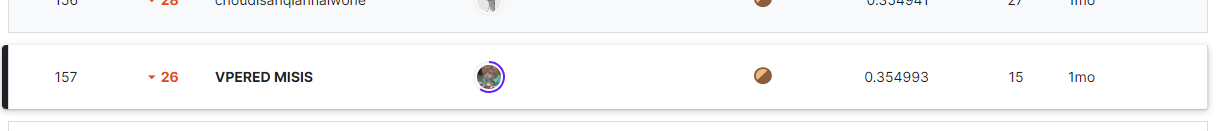